In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.functional
from torch.utils.data import DataLoader
from torchvision import utils
from torchvision.utils import save_image
from torchvision import transforms as T

import config
from datasets.classification import (
    CompressedImageDataset,
    ImageDataset,
    cifar10,
    imagenet_mini,
)
from models.classification import Classifier

# from models.compress import HyperpriorWrapper, bmshj2018_hyperprior
from utils import load_checkpoint, norm, save_checkpoint, unnorm, plot

import pickle

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_WORKERS = 16
NUM_EPOCHS = 100

train_transform = T.Compose(
    [
        T.ToTensor(),
        T.Resize(size=(256, 256)),
        T.RandomHorizontalFlip(p=0.5),
        # T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

val_transform = T.Compose(
    [
        T.ToTensor(),
        T.Resize(size=(256, 256)),
        # T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [3]:
print(config.DEVICE)

# compressor = None
# compressor = HyperpriorWrapper(
#     bmshj2018_hyperprior(config.COMPRESS_QUALITY, pretrained=True)
#     .eval()
#     .to(config.DEVICE),
#     type="s",
# )
# CH = 3 if compressor is None else 192

# model = Classifier(in_features=192*16*16, n_classes=10, hidden_layers=0, n_hidden=1024)
model = Classifier(
    in_features=192 * 16 * 16, n_classes=10, hidden_layers=0, n_hidden=1024, dropout=0.5
).to(config.DEVICE)
opt = optim.Adam(
    list(model.parameters()),
    lr=config.LEARNING_RATE,
    betas=(0.5, 0.999),
)

criterion = nn.CrossEntropyLoss()

cpu


In [4]:
if config.LOAD_MODEL:
    load_checkpoint(
        "checkpoints/clf_cifar10_compress_53.pth", model, opt, config.LEARNING_RATE
    )

=> Loading checkpoint


In [5]:
# dataset_train = CompressedImageDataset(
#     root=cifar10.train_root,
#     transform=config.transform_train
# )

dataset_val = CompressedImageDataset(
    root=cifar10.val_root, transform=config.transform_val
)

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:06<00:00,  1.64it/s]


In [6]:
# dataloader_train = DataLoader(
#     dataset_train,
#     batch_size=config.BATCH_SIZE,
#     shuffle=True,
#     num_workers=config.NUM_WORKERS,
#     pin_memory=True,
# )
dataloader_val = DataLoader(
    dataset_val,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    num_workers=config.NUM_WORKERS,
    pin_memory=True,
)

In [23]:
from tqdm import tqdm


def train(epoch, model, dataloader, opt, criterion):
    progress = tqdm(
        dataloader, leave=True, desc=f"Epoch [{epoch+1}/{config.NUM_EPOCHS}]"
    )
    log_step = len(dataloader) // 10

    losses = []
    acc = []

    model.train()
    for i, (x, y) in enumerate(progress):
        x = x.to(config.DEVICE)
        y = y.to(config.DEVICE)

        # if co:
        #     x = co.compress(x).detach()
        # else:
        #     x = norm(x)

        pred = model(x)

        loss = criterion(pred, y)

        opt.zero_grad()
        loss.backward()
        opt.step()

        losses.append(loss.item())
        acc.append((pred.argmax(dim=-1) == y).cpu().numpy().mean())

        progress.set_description(
            (
                f"train | epoch [{epoch+1}/{config.NUM_EPOCHS}] | "
                f"loss = {np.mean(losses):.3f} | "
                f"acc = {np.mean(acc):.3f} | "
            )
        )

        # if i % log_step == 0:
        #     if co:
        #         x = co.decompress(x).detach()
        #     else:
        #         x = unnorm(x)
        #     x = x[0]
        #     y = pred.argmax(dim=-1)[0]
        #     label = labels[y]
        #     save_image(x, f"results/{epoch}_{i//log_step}_{label}.png")

    return losses


def val(epoch, model, dataloader, criterion):
    progress = tqdm(
        dataloader, leave=True, desc=f"Epoch [{epoch+1}/{config.NUM_EPOCHS}]"
    )
    log_step = len(dataloader) // 10

    losses = []
    acc = []

    model.eval()
    for i, (x, y) in enumerate(progress):
        x = x.to(config.DEVICE)
        y = y.to(config.DEVICE)

        # if co:
        #     x = co.compress(x).detach()
        # else:
        #     x = norm(x)

        pred = model(x)

        loss = criterion(pred, y)

        losses.append(loss.item())
        acc.append((pred.argmax(dim=-1) == y).cpu().numpy().mean())

        progress.set_description(
            (
                f"val | epoch [{epoch+1}/{config.NUM_EPOCHS}] | "
                f"loss = {np.mean(losses):.3f} | "
                f"acc = {np.mean(acc):.3f} | "
            )
        )

        # if i == 0:
        #     if co:
        #         x = co.decompress(x).detach()
        #     else:
        #         x = unnorm(x)
        #     x = x[0]
        #     y = pred.argmax(dim=-1)[0]
        #     label = labels[y]
        #     save_image(x, f"results/{epoch}_val_{label}.png")
    return losses

In [24]:
from tqdm import tqdm

train_loss_history = []
val_loss_history = []
for epoch in range(NUM_EPOCHS):
    train_losses = train(epoch, model, dataloader_train, opt, criterion)
    train_loss_history.extend(train_losses)

    val_losses = val(epoch, model, dataloader_val, criterion)
    val_loss_history.extend(val_losses)

    plot(train_loss_history, val_loss_history)

train | epoch [1/100] | loss = 0.665 | acc = 0.771 | :   2%|▊                                     | 66/3125 [00:20<15:27,  3.30it/s]


KeyboardInterrupt: 

In [6]:
from utils import save_checkpoint

In [25]:
save_checkpoint(model, opt, "checkpoints/clf_cifar10_compress_53.pth")

=> Saving checkpoint


In [11]:
from models.compress import HyperpriorWrapper, bmshj2018_hyperprior

compressor = HyperpriorWrapper(
    bmshj2018_hyperprior(config.COMPRESS_QUALITY, pretrained=True)
    .eval()
    .to(config.DEVICE),
    type="s",
)

In [12]:
import matplotlib.pyplot as plt

%matplotlib inline

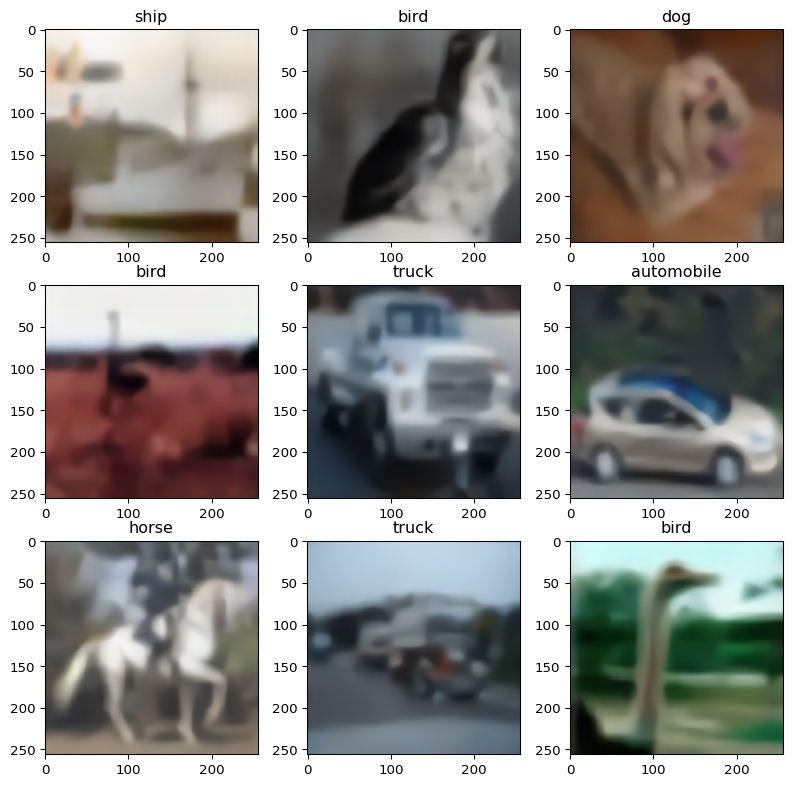

In [31]:
images, labels = iter(dataloader_val).next()
decompressed = compressor.decompress(images).detach()
plt.figure(figsize=(10, 10), dpi=96)
for i in range(9):
    plt.subplot(3, 3, i + 1)
    image = T.ToPILImage()(decompressed[i])
    label = dataset_val.labels[labels[i].item()]
    plt.imshow(image)
    plt.title(label)